In [2]:
import scanpy as sc
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
adata = sc.read_h5ad("/mnt/data2/home/leonardo/git/multilineage_velocity/benchmark/deepvelo/forebrain/deepvelo_forebrain.h5ad")

In [14]:
def plot_phase_plane(adata, gene_name, u_scale=0.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03,
                     length_includes_head=False, log=False, norm_velocity=True, filter_cells=False,
                     smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                     cell_type_key="clusters"):
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.sparse

    # Extract expression data
    gene_idx = adata.var_names.get_loc(gene_name)
    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, gene_idx]
        spliced_expression = adata.layers["Ms"][:, gene_idx]
    else:
        unspliced_expression = adata.layers["unspliced"][:, gene_idx]
        spliced_expression = adata.layers["spliced"][:, gene_idx]

    # Convert to dense arrays if needed
    if scipy.sparse.issparse(unspliced_expression):
        unspliced_expression = unspliced_expression.toarray().flatten()
    else:
        unspliced_expression = np.asarray(unspliced_expression).flatten()

    if scipy.sparse.issparse(spliced_expression):
        spliced_expression = spliced_expression.toarray().flatten()
    else:
        spliced_expression = np.asarray(spliced_expression).flatten()

    # Normalize the expression data
    unspliced_expression_min = np.min(unspliced_expression)
    unspliced_expression_max = np.max(unspliced_expression)
    spliced_expression_min = np.min(spliced_expression)
    spliced_expression_max = np.max(spliced_expression)

    # Avoid division by zero
    if unspliced_expression_max - unspliced_expression_min != 0:
        unspliced_expression = (unspliced_expression - unspliced_expression_min) / \
                               (unspliced_expression_max - unspliced_expression_min)
    else:
        unspliced_expression = unspliced_expression - unspliced_expression_min

    if spliced_expression_max - spliced_expression_min != 0:
        spliced_expression = (spliced_expression - spliced_expression_min) / \
                             (spliced_expression_max - spliced_expression_min)
    else:
        spliced_expression = spliced_expression - spliced_expression_min

    # Extract the velocity data
    unspliced_velocity = adata.layers['velocity_u'][:, gene_idx]
    spliced_velocity = adata.layers['velocity'][:, gene_idx]

    # Convert to dense arrays if needed
    if scipy.sparse.issparse(unspliced_velocity):
        unspliced_velocity = unspliced_velocity.toarray().flatten()
    else:
        unspliced_velocity = np.asarray(unspliced_velocity).flatten()

    if scipy.sparse.issparse(spliced_velocity):
        spliced_velocity = spliced_velocity.toarray().flatten()
    else:
        spliced_velocity = np.asarray(spliced_velocity).flatten()

    # Normalize velocities if required
    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))
        if max_abs_value != 0:
            scaled_data = data / max_abs_value
        else:
            scaled_data = data
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)

    # Log transform if required
    if log:
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]

    # Prepare colors for plotting
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()

    # Plot the scatter plot
    plt.figure(figsize=(9, 6.5), dpi=100)
    scatter = plt.scatter(spliced_expression_filtered, unspliced_expression_filtered, c=colors, alpha=0.6)

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        # Extract scalar values
        unspliced_vel = unspliced_velocity_filtered[i]
        spliced_vel = spliced_velocity_filtered[i]

        # Ensure the velocities are scalar floats
        if isinstance(unspliced_vel, np.ndarray):
            unspliced_vel = unspliced_vel.item()
        if isinstance(spliced_vel, np.ndarray):
            spliced_vel = spliced_vel.item()

        # Handle any potential issues with non-float values
        try:
            unspliced_vel = float(unspliced_vel)
            spliced_vel = float(spliced_vel)
        except (ValueError, TypeError):
            print(f"Non-numeric value encountered at index {i}. Skipping this point.")
            continue

        # Proceed with plotting
        cell_type = cell_types_filtered.iloc[i]
        arrow_color = celltype_to_color[cell_type]
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i],
            spliced_vel * s_scale, unspliced_vel * u_scale,
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length,
            length_includes_head=length_includes_head
        )

    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype)
               for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    if save_plot:
        plt.savefig(save_path, format='png', bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close()


In [ ]:
plot_phase_plane(adata, "Gnas")

AttributeError: 'NoneType' object has no attribute 'write'

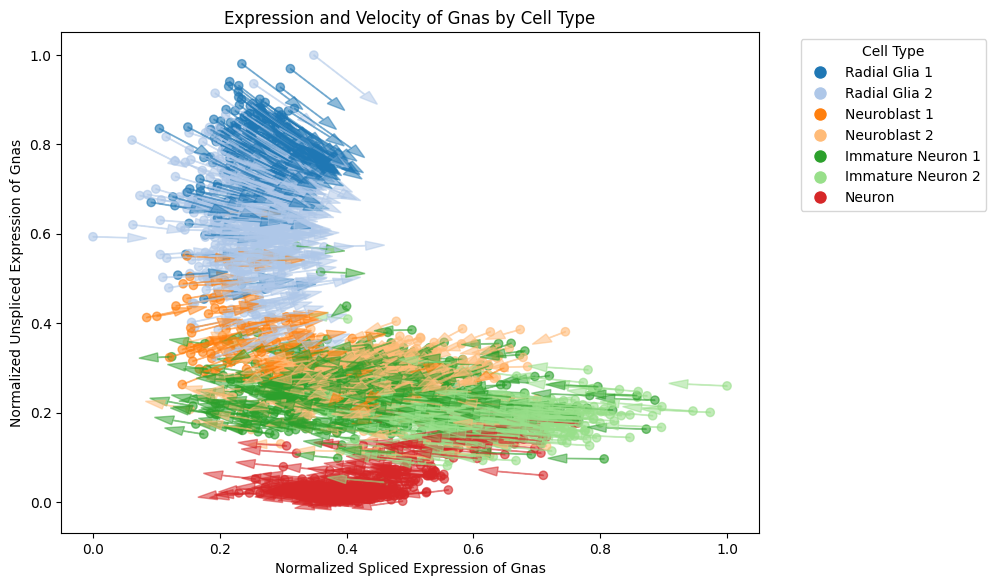

In [17]:
plot_phase_plane(adata, "Gnas", u_scale=0.1, s_scale=0.1, save_path=None, show_plot=True, cell_type_key="Clusters")

In [ ]:
adata.layers

In [ ]:
adata.layers["velocity_unspliced"]